Importowanie rzeczy

In [1]:
import pandas as pd
import tensorflow as tf
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt

from data_processor import read_data

Zbieranie zbiorów danych

In [2]:
data_dir = '../data/uniform_200k/'
datasets = []

x_eval, y_eval = read_data(data_dir, 'eval')
x_eval = np.reshape(x_eval.values, (-1, x_eval.shape[1]))
y_eval = np.reshape(y_eval.values, (-1, 1))

x_infer, y_infer = read_data(data_dir, 'infer')
x_infer = np.reshape(x_infer.values, (-1, x_infer.shape[1]))
y_infer = np.reshape(y_infer.values, (-1, 1))

def denormalize(val):
    # Read original data
    dataset = pd.read_csv('../data/uniform_200k/dataset1_200.csv')
    dataset = dataset.drop(['Unnamed: 0'], axis=1)
    
    # Calculate mean and standard deviation from original data
    avg = np.average(dataset['y'])
    std = np.std(dataset['y'])
    
    # Remove normalization from given data
    val *= std
    val += avg
    
    return val

y_eval = denormalize(y_eval)
y_infer = denormalize(y_infer)

datasets.append(('eval', x_eval, y_eval))
datasets.append(('infer', x_infer, y_infer))

Read dataset for eval from file ../data/uniform_200k/eval.csv
Read dataset for infer from file ../data/uniform_200k/infer.csv


Zbieranie wszystkich modeli do porównania

In [3]:
models = []

# CNN model
path_to_model = 'logs/run_15219734408739720318/'

cnn_model = tf.keras.models.load_model(path_to_model)
models.append(['cnn', cnn_model])

# LGBM
path_to_model = 'model.txt'
lgb_model = lgb.Booster(model_file=path_to_model)
models.append(['lgbm', lgb_model])

Zbieranie funkcji kosztu do porównywania

In [4]:
losses = []

losses.append(['mse', tf.keras.losses.MeanSquaredError()])
losses.append(['mape', tf.keras.losses.MeanAbsolutePercentageError()])

Tworzenie tabelki

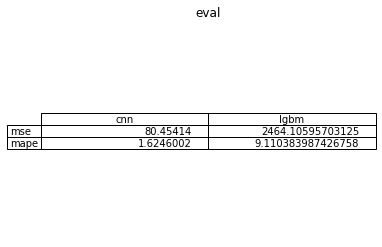

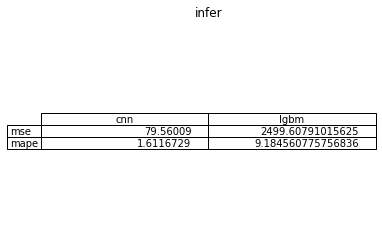

In [5]:
for dataset in datasets:
    name, X, Y = dataset
    rows = [x[0] for x in losses]    
    columns = [x[0] for x in models]

    cell_text = []
    for loss in losses:
        for model in models:
            Y_pred = model[1].predict(X)

            # Dirty trick do denormalize output
            if Y_pred[0] < 10:
                Y_pred = denormalize(Y_pred)

            val_loss = loss[1](Y, Y_pred).numpy()
            cell_text.append(str(val_loss))
        
    cell_text = np.reshape(cell_text, (len(rows), len(columns)))
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          colLabels=columns,
                          loc='center')

    plt.title(name)
    plt.axis("off")
    plt.grid(False)
    plt.show()